In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from finta import TA  # Technical Analysis Library for financial indicators

def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def prepare_data_multi_feature(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - future_window):
        window = data[i:(i + window_size)]
        X.append(window)
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

def create_lstm_model_classification(window_size, num_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(window_size, num_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ticker_symbol = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-01-01'
future_window = 1
window_size = 10

stock_data = download_stock_data(ticker_symbol, start_date, end_date)

stock_data['RSI'] = TA.RSI(stock_data)
stock_data['MA'] = TA.SMA(stock_data, 12)
stock_data['MACD'] = TA.MACD(stock_data)['MACD']
stock_data['MACD_Signal'] = TA.MACD(stock_data)['SIGNAL']

# Drop NaN values created by MA and RSI calculations
stock_data = stock_data.dropna()

stock_data['Signal'] = 0 
stock_data.loc[stock_data['MACD'] > stock_data['MACD_Signal'], 'Signal'] = 1  # Buy signal
stock_data.loc[stock_data['MACD'] < stock_data['MACD_Signal'], 'Signal'] = 0  # Sell signal

train_size = int(len(stock_data) * 0.8)
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]

train_features = train_data[['Close', 'RSI', 'MA']].values
train_labels = np.where(np.roll(train_data['Close'].values, -future_window) > train_data['Close'].values, 1, 0)[:-future_window]

scaler = MinMaxScaler(feature_range=(0, 1))
train_features_scaled = scaler.fit_transform(train_features)

X_train, y_train = prepare_data_multi_feature(train_features_scaled, train_labels, window_size)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))


model = create_lstm_model_classification(window_size, X_train.shape[2])


[*********************100%%**********************]  1 of 1 completed


/var/folders/04/w3ml6jcn3zg65sc3958sg05w0000gn/T/ipykernel_90103/1326734881.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Signal'] = 0  # Default value - no action


In [278]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
82/82 [==============================] - 12s 125ms/step - loss: 0.6924 - accuracy: 0.5191
Epoch 2/10
82/82 [==============================] - 8s 101ms/step - loss: 0.6925 - accuracy: 0.5279
Epoch 3/10
82/82 [==============================] - 8s 103ms/step - loss: 0.6916 - accuracy: 0.5279
Epoch 4/10
82/82 [==============================] - 9s 104ms/step - loss: 0.6918 - accuracy: 0.5279
Epoch 5/10
82/82 [==============================] - 8s 100ms/step - loss: 0.6923 - accuracy: 0.5279
Epoch 6/10
82/82 [==============================] - 8s 103ms/step - loss: 0.6918 - accuracy: 0.5260
Epoch 7/10
82/82 [==============================] - 8s 100ms/step - loss: 0.6914 - accuracy: 0.5283
Epoch 8/10
82/82 [==============================] - 9s 104ms/step - loss: 0.6915 - accuracy: 0.5306
Epoch 9/10
82/82 [==============================] - 8s 101ms/step - loss: 0.6914 - accuracy: 0.5291
Epoch 10/10
82/82 [==============================] - 9s 111ms/step - loss: 0.6914 - accuracy: 0.529

In [279]:
test_features = test_data[['Close', 'RSI', 'MA']].values
test_labels = np.where(np.roll(test_data['Close'].values, -future_window) > test_data['Close'].values, 1, 0)[:-future_window]

test_features_scaled = scaler.transform(test_features) # Use the same scaler as the training data
X_test, y_test = prepare_data_multi_feature(test_features_scaled, test_labels, window_size)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

predicted_signals = model.predict(X_test) > 0.5# using 0.5 as threshold

21/21 [==============================] - 1s 23ms/step


Accuracy: 50.62%


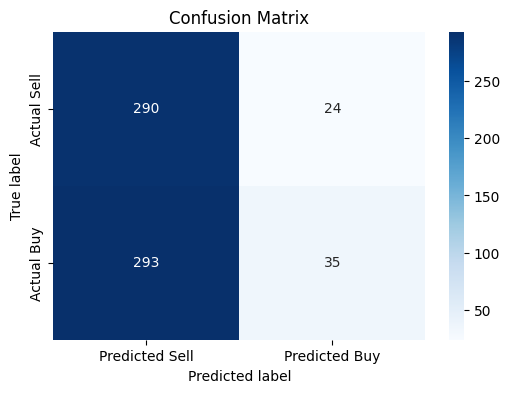

In [280]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns  # For plotting
import matplotlib.pyplot as plt

start_idx = window_size + future_window-1
adjusted_close_prices = test_data['Close'][start_idx:start_idx + len(predicted_signals)].reset_index(drop=True)

predicted_labels = predicted_signals.flatten()
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Sell', 'Predicted Buy'], 
            yticklabels=['Actual Sell', 'Actual Buy'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [281]:
initial_capital = 10000.0
capital = initial_capital
shares_owned = 0

for i in range(len(predicted_signals)):
    current_price = adjusted_close_prices[i]
    signal = predicted_signals[i]

    if signal and capital > 0:
        shares_owned = capital / current_price
        capital = 0  # All capital is used to buy shares

    elif not signal and shares_owned > 0:
        capital = shares_owned * current_price
        shares_owned = 0  # All shares are sold

final_portfolio_value = capital + (shares_owned * adjusted_close_prices[len(adjusted_close_prices)-1])

print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Profit/Loss: ${final_portfolio_value - initial_capital:.2f}")


Initial Capital: $10000.00
Final Portfolio Value: $13157.24
Profit/Loss: $3157.24
